In [309]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import cv2
from sklearn import metrics
import threading as th
from tqdm import tqdm as progress_bar

In [2]:
!ls


best_so_far.png					 projekt.ipynb	todo.txt
Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg  README.md


In [5]:
target_img.shape

(749, 512)

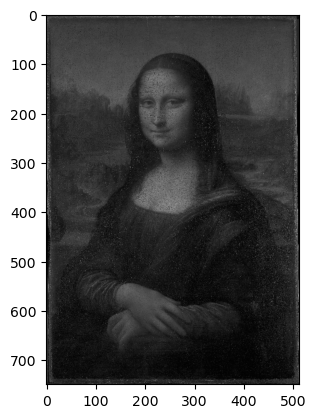

In [46]:
resize_to=512
target_img=cv2.imread('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg')
#Image.open('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg')
target_img=cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

hw_ratio=target_img.shape[0]/target_img.shape[1]
target_img=cv2.resize(target_img, (resize_to, int(hw_ratio*resize_to))) # widtxXheight
target_img=np.asarray(target_img)/255

plt.imshow(target_img, cmap='gray')
plt.show()

# define circles

In [11]:
class Circle:
    def __init__(self, cords, r, o, rgb, image_shape=(381, 256, 3)):
        self.x=cords[0] 
        self.y=cords[1]
        
        self.radius=r
        self.opacity=o
        self.rgb=rgb
       # self.g=rgb[1]
       # self.b=rgb[2]
        
        self.img_shape=image_shape
    def get_patch(self):
        return plt.Circle((self.x, self.y), 
                          radius=self.radius, 
                          alpha=self.opacity,
                          color=self.rgb)
    def draw_cv2(self, X):
        return cv2.circle(X, 
                  (self.x, self.y), 
                  self.radius, 
                  self.rgb,
                  thickness=-1)
        

In [12]:
def random_circle(max_radius=target_img.shape[1]):
    cords_seed=np.random.random(2)
    cords=(int(cords_seed[0]*target_img.shape[1]),
           int(cords_seed[1]*target_img.shape[0]))
    r=int(np.random.random()*100)
    o=np.random.random()
    rgb=np.random.random(3)
    return Circle(cords, r, o, rgb)

In [13]:

no_circles=100
# each circle has LOCATION (x,y), RADIUS, OPACITY, COLOUR (rgb), 
circles=[]
for i in range(no_circles):
    circles.append(random_circle())

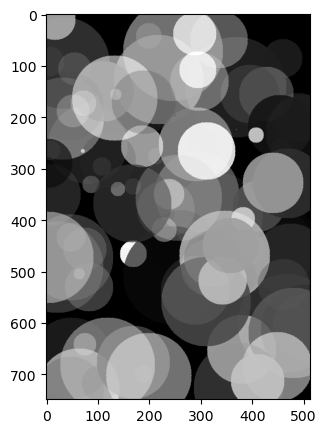

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

X=np.zeros(target_img.shape)
for c in circles:
  #  circle_img=X.copy()
    circle_img=c.draw_cv2(X.copy())
    X=cv2.addWeighted(X, 1-c.opacity, circle_img, c.opacity, 0)

plt.imshow(X, cmap='gray')
plt.show()

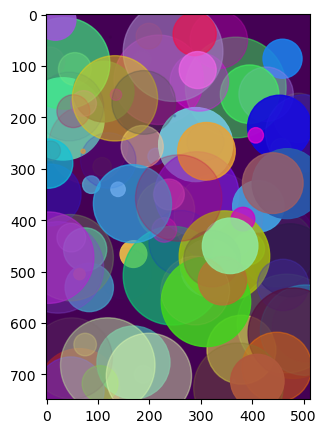

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))


X=np.zeros(target_img.shape)
ax.imshow(X)
for c in circles:
    ax.add_patch(c.get_patch())
plt.show()

# ES

In [353]:
def random_circle(gray=False, 
                  max_radius_scale=1.0, max_opacity_scale=1.0):
    '''Function generating random circles.
    Cirlce is presented as a numpy array lenght 8 in such scheme
    [x, y, radius, opacity, r, g, b]

    Returns:
        circle (numpy array length 7): the generated circle
    '''
    if gray:
        lows=np.zeros(5)
        highs=np.ones(5)
        lows[2]=0.25*max_radius_scale
        highs[2]=1.0*max_radius_scale
        highs[3]=1.0* max_opacity_scale
        
        circle=np.random.uniform(lows, highs, 5)
    else:
        lows=np.zeros(7)
        highs=np.ones(7)
        lows[2]=0.25*max_radius_scale
        highs[2]=1.0*max_radius_scale
        highs[3]=1.0* max_opacity_scale
       
        circle=np.random.uniform(lows, highs, 7)
    return circle

In [357]:
def random_individual(chromosome_length, genotype_len=7, gray=False, 
                      max_radius_scale=1.0,  max_opacity_scale=1.0):
    '''Function generating random individual.
    Args:
        chromosome_length (int): number of figures in an individual
        genotype (int): lenght of a gene (defaults 7 for circle)
    Returns:
        indiv (numpy array shaped (chromosome_length, genotype)): the generated individual
    '''
    indiv = np.zeros((chromosome_length, genotype_len))
    if gray:
        if genotype_len == 5: # circle
            for i in range(chromosome_length):
                indiv[i] = random_circle(gray, 
                                         max_radius_scale=max_radius_scale, 
                                         max_opacity_scale=max_opacity_scale)
    else:
        if genotype_len == 7: # circle
            for i in range(chromosome_length):
                indiv[i] = random_circle(max_radius_scale=max_radius_scale,
                                         max_opacity_scale=max_opacity_scale)
    
    return indiv

In [356]:
def random_population(population_size, chromosome_length, genotype_len=7, gray=False, 
                      max_radius_scale=1.0, max_opacity_scale=1.0):
    '''Function generating random population.
    Args:
        population_size (int): number of individuals in the population
        chromosome_length (int): number of figures in and individual
        genotype (int): length of a gene (defaults 7 for circle)
    
    Returns:
        population: generated population
    '''
    population = np.zeros((population_size, chromosome_length, genotype_len))
    for i in range(population_size):
        population[i] = random_individual(chromosome_length, genotype_len, gray, 
                                          max_radius_scale, max_opacity_scale)
    
    return population

In [232]:
max_radius=np.sqrt(pow(target_img.shape[0],2)+pow(target_img.shape[1], 2))/2

def represent_individual(X):
    X_img=np.zeros(target_img.shape)
    for c in X:
        #[x, y, radius, opacity, r, g, b]
        x=int(c[0]*target_img.shape[1])
        y=int(c[1]*target_img.shape[0])
        radius=int(c[2]*max_radius)
        opacity=c[3]
        rgb=c[4:]
        circle_img=cv2.circle(X_img.copy(), 
                              (x, y), 
                              radius, 
                              rgb,
                              thickness=-1)
        X_img=cv2.addWeighted(X_img, 1-opacity, circle_img, opacity, 0)
    return X_img

In [376]:
def draw_individual(X_img, gray=True):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.show()
def save_individual_img(X_img, gray=True, no_iter=0, dir_path='./best_X_imgs/'):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.savefig(dir_path+f'iter_{no_iter}')
    plt.show()

In [234]:
#flatten_target_image=target_img.flatten()
def MSE_objective_f(X_img):
    #return metrics.mean_squared_error(flatten_target_image, X_img.flatten())
    pom = target_img - X_img
    return np.sum(pom*pom)

In [389]:
def mutate_population(population, scale=1e-1, mut_prob=0.4):
    mutation_indices = (np.random.random(population.shape) < mut_prob).astype(float)
    population += mutation_indices * (np.random.randn(*population.shape)-0.5) * scale
    population = np.clip(population, 0, 1)
    return population

In [235]:
def mutate_X(X, scale=1e-1):
    no_figures_to_mutate=np.random.randint(1, X.shape[0]//2)
    figures_to_mutate=np.random.choice(np.arange(X.shape[0]), no_figures_to_mutate, replace=False)
    
    X[figures_to_mutate]=np.clip(X[figures_to_mutate]+(np.random.random((no_figures_to_mutate,
                                                                         X.shape[1]))-0.5)*scale, 0, 1)
    return X

In [397]:
def mutate_X_thred(solutions, i, scale=1e-1):
    no_figures_to_mutate=np.random.randint(1, solutions[i].shape[0]//2)
    figures_to_mutate=np.random.choice(np.arange(solutions[i].shape[0]), no_figures_to_mutate, replace=False)
    
    solutions[i,figures_to_mutate]=np.clip(solutions[i,figures_to_mutate]+(np.random.random((no_figures_to_mutate,
                                                                         solutions[i].shape[1]))-0.5)*scale, 0, 1)
    #return X

19496.642954735595
[[0.25487368 0.80502804 0.73160683 0.8115762  0.50094242]
 [0.40901845 0.24168646 0.5556863  0.91423846 0.11824311]
 [0.30732216 0.01987095 0.27454565 0.72700297 0.11135223]
 [0.75224392 0.82480434 0.85924787 0.18685715 0.4230991 ]]
(749, 512)


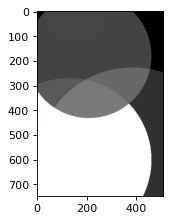

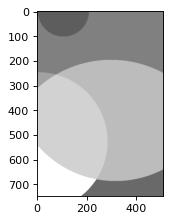

In [363]:
rpop=random_population(10, 4, genotype_len=5, gray=True)
print(MSE_objective_f(represent_individual(rpop[0])))
print(rpop[0])
print(represent_individual(rpop[0]).shape)
draw_individual(represent_individual(rpop[0]))
mutated=rpop[0].copy()
for i in range(100):
    mutated=mutate_X(mutated)
draw_individual(represent_individual(mutated))

In [245]:
def evaluate_individual(evals, i, X, f):
    evals[i]=f(represent_individual(X))

In [388]:
np.clip(random_population(10,8), 0.1, 0.5).shape

(10, 8, 7)

In [398]:
def es(
    objective_function, 
    chromosome_length,
    genotype_length,
    population_size, 
    number_of_iterations, 
    number_of_parents, 
    number_of_offspring_per_parent=3, 
    mutation_scale=1e-1,
    max_chromosome_length=128,
    gray=False,
  #  sigma, 
  #  tau, 
  #  tau_0, 
    log_frequency=1,
    pararell=False
):

   # print(chromosome_length)
    best_solution = np.zeros((max_chromosome_length, genotype_length))
    best_solution_objective_value = np.inf

    
    log_objective_values = np.zeros((number_of_iterations, 4))
    log_best_solutions = []#np.zeros((number_of_iterations, max_chromosome_length, genotype_length))
   # log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions=random_population(population_size, chromosome_length, genotype_length, gray)
   # current_population_solutions[::2]=0.5
  #  current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values=np.ones(current_population_solutions.shape[0])
    if pararell:
        threads=[]
        for i in range(population_size):
            t=th.Thread(target=evaluate_individual, args=[current_population_objective_values, i,
                                                          current_population_solutions[i], objective_function])
            t.start()
            threads.append(t)
        for t in threads:
            t.join()
    else:
        current_population_objective_values = np.asarray([objective_function(represent_individual(X)) for X in current_population_solutions])
    #objective_function(current_population_solutions)
  #  print(current_population_objective_values)
    try:
        times_circles_were_added=1 # initial creation of population
        last_update_iter=0
        start_mutations_scale=mutation_scale
        for no_iter in progress_bar(range(number_of_iterations)):

            # selecting the parent indices by the roulette wheel method
            # MAXIMIZE
            #fitness_values = current_population_objective_values - current_population_objective_values.min()
            # MINIMIZE
            fitness_values = current_population_objective_values.max() - current_population_objective_values
            if fitness_values.sum() > 0:
                fitness_values = fitness_values / fitness_values.sum()
            else:
                fitness_values = 1.0 / population_size * np.ones(population_size)
            parent_indices = np.random.choice(population_size, number_of_parents, True, fitness_values).astype(np.int64)

            # creating the children population by Global Intermediere Recombination
            children_list=[]
            for i in range(number_of_offspring_per_parent):
                children_list.append(current_population_solutions[parent_indices].copy())          
            children_population_solutions = np.vstack(children_list)
            
        #    for i in range(children_population_solutions.shape[0]):
         #       children_population_solutions[i]=mutate_X(children_population_solutions[i], 
          #                                                scale=mutation_scale)
            
            if pararell:
                threads=[]
                for i in range(children_population_solutions.shape[0]):
                    t=th.Thread(target=mutate_X_thred, args=[children_population_solutions, i, 
                                                             mutation_scale])
                    t.start()
                    threads.append(t)
                for t in threads:
                    t.join()
            else:
                for i in range(children_population_solutions.shape[0]):
                    children_population_solutions[i]=mutate_X(children_population_solutions[i], 
                                                              scale=mutation_scale)
            #children_population_solutions=mutate_population(children_population_solutions,
            #                                               scale=mutation_scale)
            
            
            #np.empty((number_of_offspring, chromosome_length), dtype=Circle)
            #children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))

           # for i in range(number_of_offspring):
            #    children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
             #   children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

            # mutating the children population by adding random gaussian noise
          #  children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
           # children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

            # evaluating the objective function on the children population
            children_population_objective_values=np.ones(number_of_offspring_per_parent*number_of_parents)
            if pararell:
                threads=[]
                for i in range(children_population_solutions.shape[0]):
                    t=th.Thread(target=evaluate_individual, args=[children_population_objective_values, i,
                                                                  children_population_solutions[i], objective_function])
                    t.start()
                    threads.append(t)
                for t in threads:
                    t.join()
            else:
                children_population_objective_values = [objective_function(represent_individual(X)) for X in children_population_solutions]

            # replacing the current population by (Mu + Lambda) Replacement
            current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
            current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
           # current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

            I = np.argsort(current_population_objective_values)#[::-1]
            current_population_solutions = current_population_solutions[I[:population_size], :]
        #    current_population_sigmas = current_population_sigmas[I[:population_size], :]
            current_population_objective_values = current_population_objective_values[I[:population_size]]

            # recording some statistics
            if best_solution_objective_value > current_population_objective_values[0]:
                best_solution = current_population_solutions[0, :]
                best_solution_objective_value = current_population_objective_values[0]

         #   print(no_iter, current_population_objective_values.min(), 
        #          current_population_objective_values.max(), 
         #         current_population_objective_values.mean(), 
        #          current_population_objective_values.std())
            log_objective_values[no_iter, :] = [current_population_objective_values.min(), 
                                                current_population_objective_values.max(),
                                                current_population_objective_values.mean(), 
                                                current_population_objective_values.std()]

           # print(log_best_solutions.shape, current_population_solutions.shape )
           # log_best_solutions[no_iter, :] = current_population_solutions[0, :]

           # log_best_sigmas[t, :] = current_population_sigmas[0, :]

            if np.mod(no_iter, log_frequency) == 0 or no_iter==number_of_iterations-1:
                
                log_best_solutions.append(current_population_solutions[0, :])
                print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (no_iter, 
                                                                                    log_objective_values[no_iter, 0], 
                                                                                    log_objective_values[no_iter, 2]))
                #draw_individual(represent_individual(best_solution), gray)
                save_individual_img(represent_individual(best_solution), gray, no_iter=no_iter)
                
                if no_iter-last_update_iter>=times_circles_were_added*400 and no_iter>2*log_frequency:
                    prev=np.mean(log_objective_values[no_iter-2*log_frequency:no_iter-log_frequency])
                    curr=np.mean(log_objective_values[no_iter-log_frequency:no_iter+1])
                    if (prev-curr)/prev < 0.005: # ADD CIRCLES
                        
                        last_update_iter=no_iter
                        times_circles_were_added+=1
                        best_solution_objective_value=np.inf
                        mutation_scale=start_mutations_scale/times_circles_were_added
                        
                        radius_scale=1/(2*times_circles_were_added)
                        if radius_scale<1/16:
                            radius_scale=1/16
                                
                        new_pop=random_population(population_size, chromosome_length, 
                                                  genotype_length, gray, 
                                                  max_radius_scale=radius_scale,
                                                  max_opacity_scale=0.5)
                        current_population_solutions=np.concatenate([current_population_solutions, new_pop], 
                                                                    axis=1)
                        print(f'Added more circles of radius_scale={radius_scale}, mutation scale={mutation_scale}.\n New population shape: {current_population_solutions.shape}')
                        
                        if pararell:
                            threads=[]
                            for i in range(population_size):
                                t=th.Thread(target=evaluate_individual, args=[current_population_objective_values, i,
                                                                              current_population_solutions[i], objective_function])
                                t.start()
                                threads.append(t)
                            for t in threads:
                                t.join()
                        else:
                            current_population_objective_values = np.asarray([objective_function(represent_individual(X)) for X in current_population_solutions])

        
    except KeyboardInterrupt:
        print('Interrupted')
    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, current_population_solutions

  0%|                                                 | 0/30000 [00:00<?, ?it/s]

Iteration 0000 : best score = 7322.71670113, mean score = 15160.00809191.


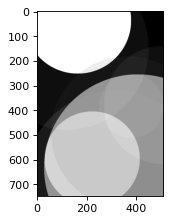

  0%|                                     | 100/30000 [00:28<2:21:25,  3.52it/s]

Iteration 0100 : best score = 2578.51509865, mean score = 2594.97718601.


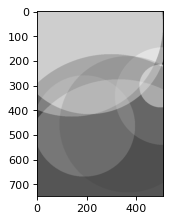

  1%|▏                                    | 200/30000 [00:57<2:22:16,  3.49it/s]

Iteration 0200 : best score = 2448.85459510, mean score = 2458.57099852.


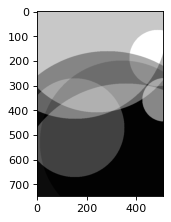

  1%|▎                                    | 300/30000 [01:26<2:20:53,  3.51it/s]

Iteration 0300 : best score = 2431.48154521, mean score = 2434.41720899.


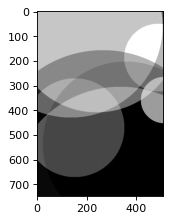

  1%|▍                                    | 400/30000 [01:54<2:19:27,  3.54it/s]

Iteration 0400 : best score = 2420.12084661, mean score = 2422.57809202.


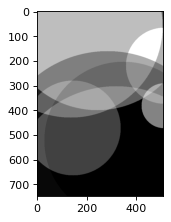

  2%|▌                                    | 500/30000 [02:23<2:19:07,  3.53it/s]

Iteration 0500 : best score = 2416.10728807, mean score = 2418.53639781.


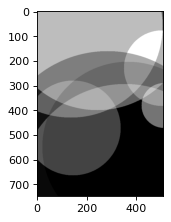

Added more circles of radius_scale=0.25, mutation scale=0.05.
 New population shape: (32, 16, 5)


  2%|▋                                    | 600/30000 [03:13<4:04:21,  2.01it/s]

Iteration 0600 : best score = 2084.21355695, mean score = 2088.30482972.


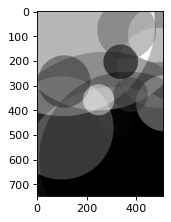

  2%|▊                                    | 700/30000 [04:03<4:10:26,  1.95it/s]

Iteration 0700 : best score = 1990.64856530, mean score = 2000.29921425.


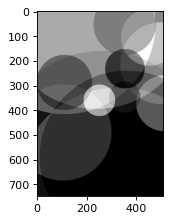

  3%|▉                                    | 800/30000 [04:53<4:02:07,  2.01it/s]

Iteration 0800 : best score = 1953.15896146, mean score = 1956.53853588.


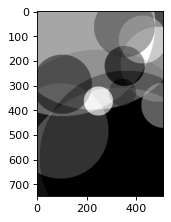

  3%|█                                    | 900/30000 [05:44<4:02:53,  2.00it/s]

Iteration 0900 : best score = 1936.10587264, mean score = 1939.54213781.


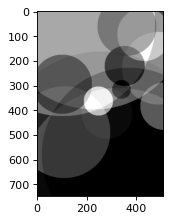

  3%|█▏                                  | 1000/30000 [06:34<4:01:29,  2.00it/s]

Iteration 1000 : best score = 1915.51764403, mean score = 1919.46666293.


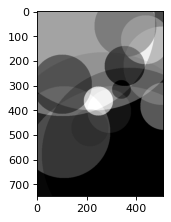

  4%|█▎                                  | 1100/30000 [07:24<4:08:43,  1.94it/s]

Iteration 1100 : best score = 1906.35998019, mean score = 1908.45562735.


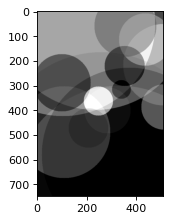

  4%|█▍                                  | 1200/30000 [08:15<3:59:14,  2.01it/s]

Iteration 1200 : best score = 1889.19345328, mean score = 1893.95341512.


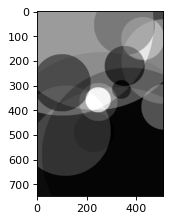

  4%|█▌                                  | 1300/30000 [09:05<3:57:59,  2.01it/s]

Iteration 1300 : best score = 1878.08083346, mean score = 1882.53712803.


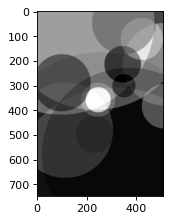

  5%|█▋                                  | 1400/30000 [09:54<3:57:39,  2.01it/s]

Iteration 1400 : best score = 1865.45565053, mean score = 1868.28710567.


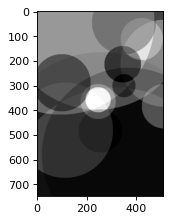

  5%|█▊                                  | 1500/30000 [10:44<3:56:26,  2.01it/s]

Iteration 1500 : best score = 1863.83091148, mean score = 1865.68216020.


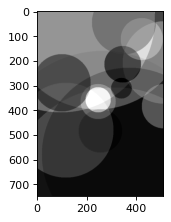

Added more circles of radius_scale=0.16666666666666666, mutation scale=0.03333333333333333.
 New population shape: (32, 24, 5)


  5%|█▉                                  | 1600/30000 [11:56<5:35:49,  1.41it/s]

Iteration 1600 : best score = 1728.72707687, mean score = 1734.85042029.


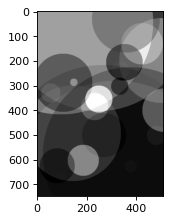

  6%|██                                  | 1700/30000 [13:07<5:35:03,  1.41it/s]

Iteration 1700 : best score = 1698.72618347, mean score = 1700.79390893.


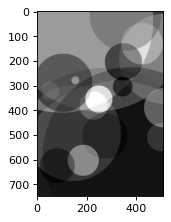

  6%|██▏                                 | 1800/30000 [14:18<5:34:24,  1.41it/s]

Iteration 1800 : best score = 1677.04184191, mean score = 1679.48639550.


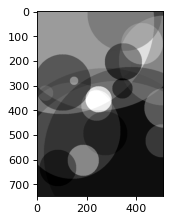

  6%|██▎                                 | 1900/30000 [15:30<5:32:46,  1.41it/s]

Iteration 1900 : best score = 1670.39940400, mean score = 1671.65964356.


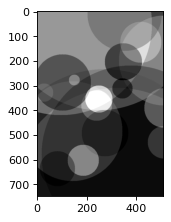

  7%|██▍                                 | 2000/30000 [16:41<5:31:55,  1.41it/s]

Iteration 2000 : best score = 1661.66500153, mean score = 1663.29341646.


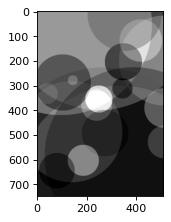

  7%|██▌                                 | 2100/30000 [17:52<5:31:45,  1.40it/s]

Iteration 2100 : best score = 1657.76708194, mean score = 1658.82300353.


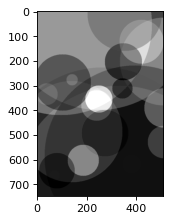

  7%|██▋                                 | 2200/30000 [19:04<5:29:49,  1.40it/s]

Iteration 2200 : best score = 1655.43674748, mean score = 1656.09547879.


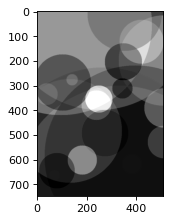

  8%|██▊                                 | 2300/30000 [20:15<5:28:08,  1.41it/s]

Iteration 2300 : best score = 1652.50625947, mean score = 1653.82705851.


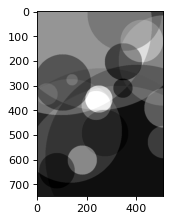

  8%|██▉                                 | 2400/30000 [21:26<5:27:16,  1.41it/s]

Iteration 2400 : best score = 1648.65672597, mean score = 1650.06032345.


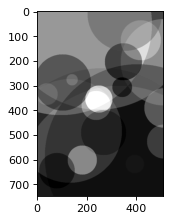

  8%|███                                 | 2500/30000 [22:37<5:25:15,  1.41it/s]

Iteration 2500 : best score = 1646.57227971, mean score = 1647.50902128.


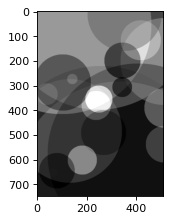

  9%|███                                 | 2600/30000 [23:49<5:25:13,  1.40it/s]

Iteration 2600 : best score = 1641.79477270, mean score = 1644.21725100.


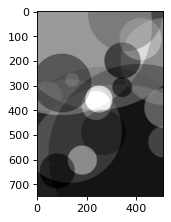

  9%|███▏                                | 2700/30000 [25:00<5:23:16,  1.41it/s]

Iteration 2700 : best score = 1634.56470153, mean score = 1636.01128678.


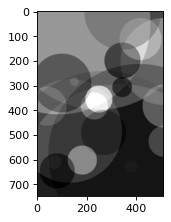

Added more circles of radius_scale=0.125, mutation scale=0.025.
 New population shape: (32, 32, 5)


  9%|███▎                                | 2800/30000 [26:33<6:58:37,  1.08it/s]

Iteration 2800 : best score = 1624.46280824, mean score = 1627.26944978.


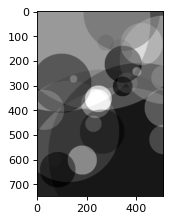

 10%|███▍                                | 2900/30000 [28:06<6:57:29,  1.08it/s]

Iteration 2900 : best score = 1608.55243751, mean score = 1610.71675071.


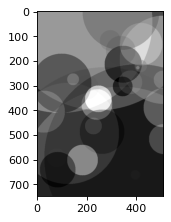

 10%|███▌                                | 3000/30000 [29:38<6:55:46,  1.08it/s]

Iteration 3000 : best score = 1594.91244428, mean score = 1599.76403866.


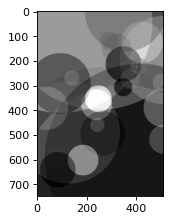

 10%|███▋                                | 3100/30000 [31:11<6:53:27,  1.08it/s]

Iteration 3100 : best score = 1583.92485527, mean score = 1585.12748011.


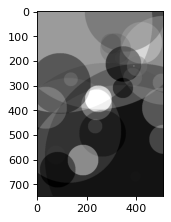

 11%|███▊                                | 3200/30000 [32:43<6:53:35,  1.08it/s]

Iteration 3200 : best score = 1577.06353597, mean score = 1578.16640524.


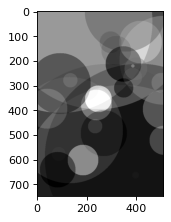

 11%|███▉                                | 3300/30000 [34:16<6:51:49,  1.08it/s]

Iteration 3300 : best score = 1568.95919831, mean score = 1569.89771170.


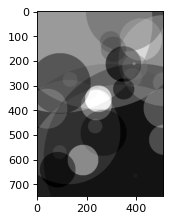

 11%|████                                | 3400/30000 [35:48<6:49:23,  1.08it/s]

Iteration 3400 : best score = 1562.33450459, mean score = 1563.37587840.


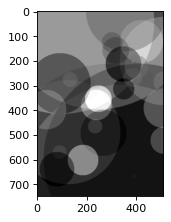

 12%|████▏                               | 3500/30000 [37:21<6:48:53,  1.08it/s]

Iteration 3500 : best score = 1557.19717682, mean score = 1557.69633744.


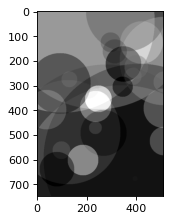

 12%|████▎                               | 3600/30000 [38:54<6:52:18,  1.07it/s]

Iteration 3600 : best score = 1553.40746156, mean score = 1554.39394881.


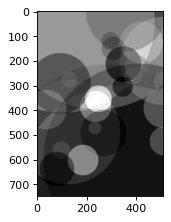

 12%|████▍                               | 3700/30000 [40:27<6:45:14,  1.08it/s]

Iteration 3700 : best score = 1550.57318415, mean score = 1551.19199674.


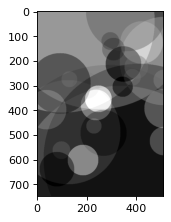

 13%|████▌                               | 3800/30000 [42:00<6:47:22,  1.07it/s]

Iteration 3800 : best score = 1547.42846247, mean score = 1547.93946283.


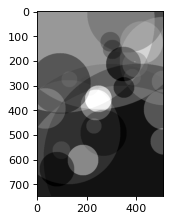

 13%|████▋                               | 3900/30000 [43:33<6:42:09,  1.08it/s]

Iteration 3900 : best score = 1544.99577412, mean score = 1546.12107488.


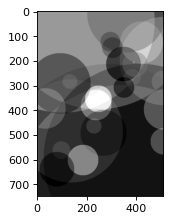

 13%|████▊                               | 4000/30000 [45:06<6:42:20,  1.08it/s]

Iteration 4000 : best score = 1543.41554540, mean score = 1543.99140536.


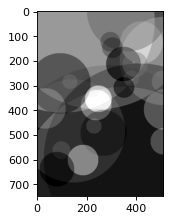

 14%|████▉                               | 4100/30000 [46:39<6:38:27,  1.08it/s]

Iteration 4100 : best score = 1539.82778987, mean score = 1541.48939706.


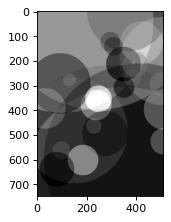

 14%|█████                               | 4200/30000 [48:12<6:37:13,  1.08it/s]

Iteration 4200 : best score = 1537.36363293, mean score = 1537.92374913.


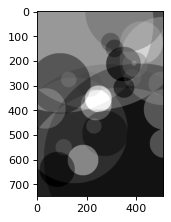

 14%|█████▏                              | 4300/30000 [49:44<6:36:33,  1.08it/s]

Iteration 4300 : best score = 1535.45233164, mean score = 1536.58649016.


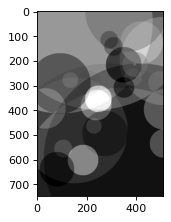

Added more circles of radius_scale=0.1, mutation scale=0.02.
 New population shape: (32, 40, 5)


 15%|█████▎                              | 4400/30000 [51:39<8:03:48,  1.13s/it]

Iteration 4400 : best score = 1552.73920511, mean score = 1554.16364740.


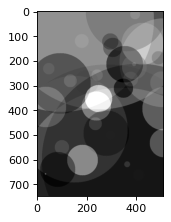

 15%|█████▍                              | 4500/30000 [53:33<8:02:10,  1.13s/it]

Iteration 4500 : best score = 1540.07798964, mean score = 1541.28112347.


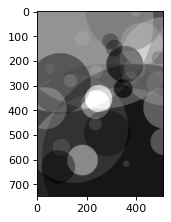

 15%|█████▌                              | 4600/30000 [55:27<8:15:39,  1.17s/it]

Iteration 4600 : best score = 1530.45771277, mean score = 1531.16348440.


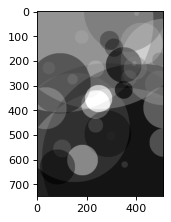

 15%|█████▌                              | 4642/30000 [56:16<8:08:00,  1.15s/it]

In [ ]:
'''def es(
    objective_function, 
    individual_size,
    population_size, 
    number_of_iterations, 
    number_of_parents, 
number_of_offspring_per_parent  #  sigma, 
  #  tau, 
  #  tau_0, 
    log_frequency=1
):'''
no_iters=30000


best_solution_objective_value, best_solution, \
log_objective_values, log_best_solutions, population=es(MSE_objective_f, 
                                             chromosome_length=8,
                                             population_size=32,
                                            number_of_iterations=no_iters,
                                            number_of_parents=6,
                                            number_of_offspring_per_parent=6,

                                            genotype_length=5, gray=True,

                                            pararell=True, log_frequency=100)
np.save('./last_population', population)

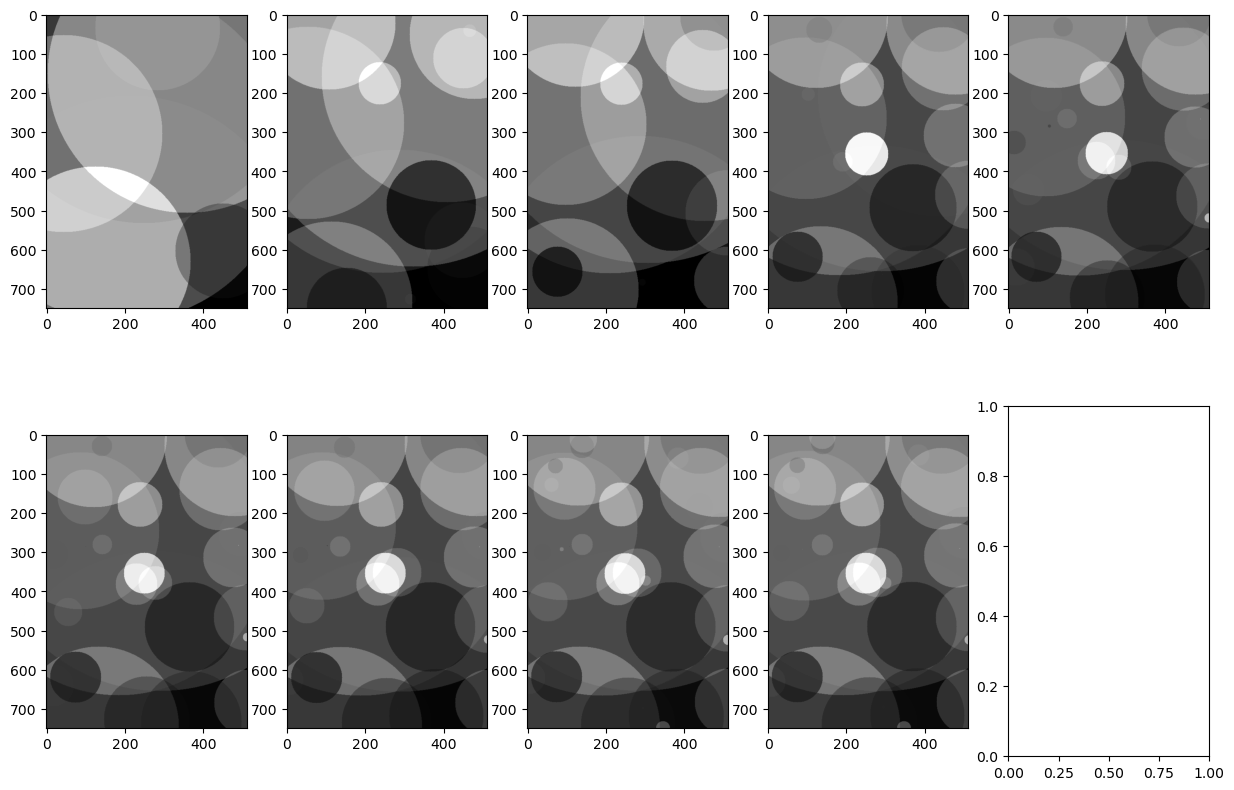

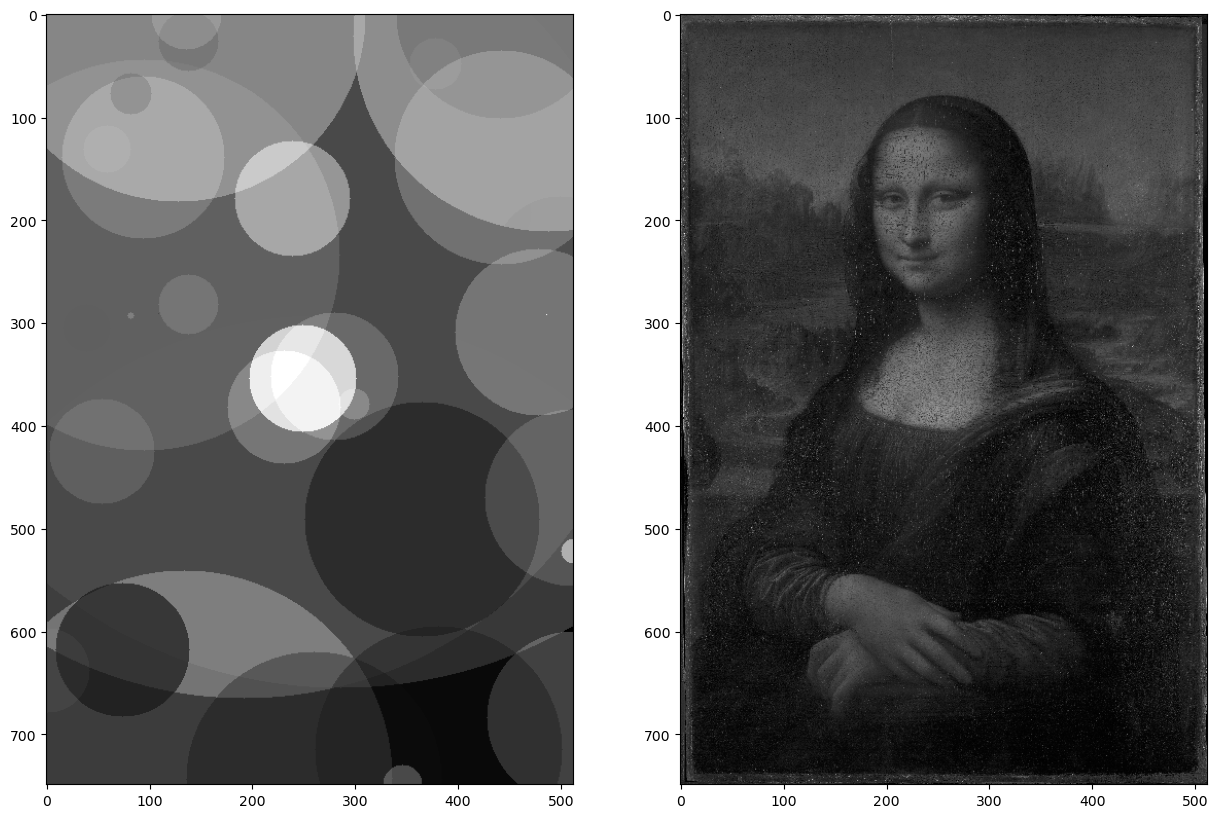

In [370]:
mod_val=(10+len(log_best_solutions))//10

fig, axs = plt.subplots(2, 5, figsize=(15,10))
col_counter=0
row_counter=0
for i, X in enumerate(log_best_solutions[:-1]):
    if i%mod_val==0:
        axs[row_counter, col_counter].imshow(represent_individual(X), cmap='gray')
        col_counter+=1
        if col_counter>4:
            col_counter=0
            row_counter+=1
        #draw_individual(represent_individual(X))
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(represent_individual(best_solution), cmap='gray')
axs[1].imshow(target_img, cmap='gray')
plt.show()

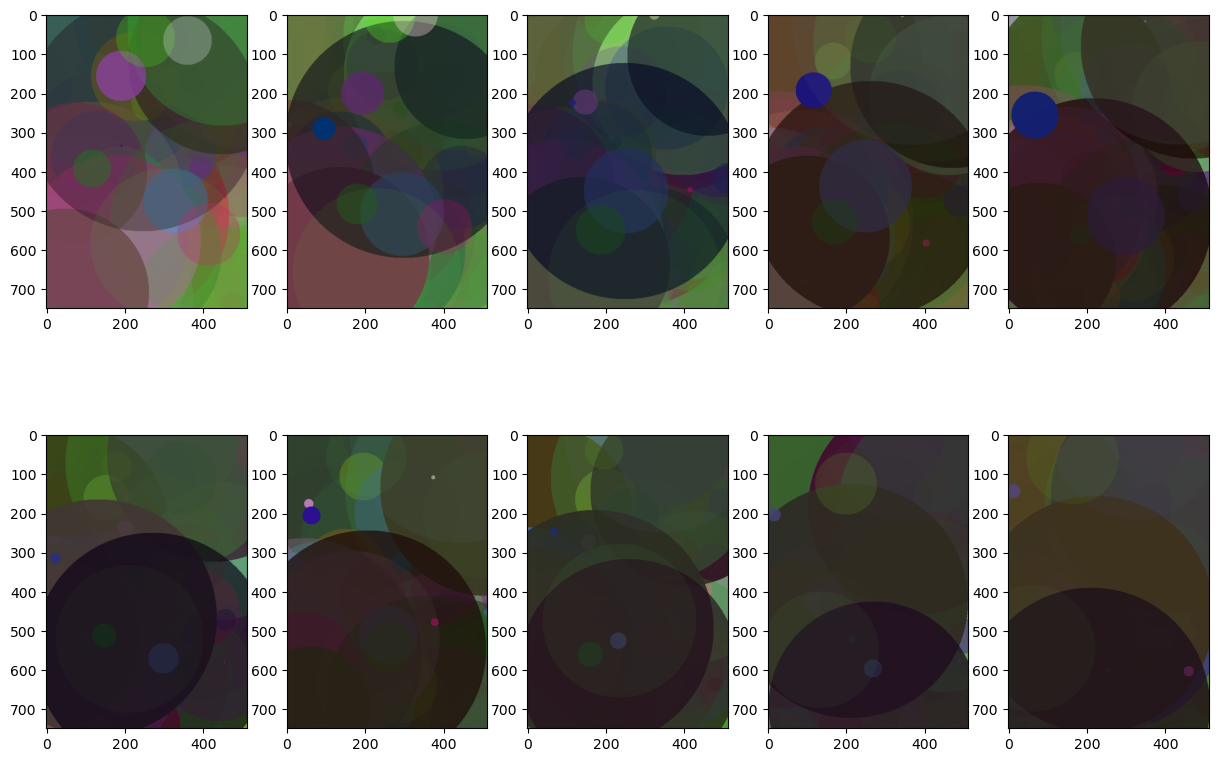

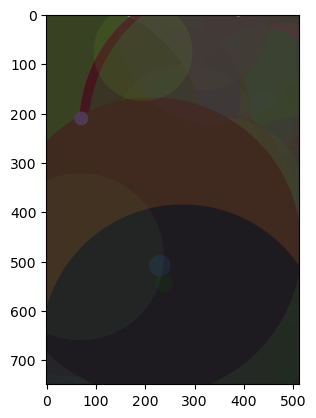

In [49]:

fig, axs = plt.subplots(log_best_solutions.shape[0]//50, 5, figsize=(15,10))
col_counter=0
row_counter=0
for i, X in enumerate(log_best_solutions):
    if i%10==0:
        axs[row_counter, col_counter].imshow(represent_individual(X))
        col_counter+=1
        if col_counter>4:
            col_counter=0
            row_counter+=1
        #draw_individual(represent_individual(X))
plt.show()
draw_individual(represent_individual(best_solution))